# <center>Analisis de datos para el Dataset Games</center>

# Introducción

En este proyecto pondremos a prueba los conocimientos adquiridos hasta este punto, veremos la importación de datos, la limpieza, el analisis, prueba de hipotesis y conclusiones de todo el proyecto. 

A lo largo del cuadernos podremos observar las diferentes secciones, donde se incluye el codigo y comentarios para saber como se fueron interpretando los datos, que decisión se tomo una vez visto errores, o cualquier inconsistencia. 

Al final del proyecto podremos observar cuales son las plataformas que más se venden, las regiones que más se venden y los generos que atraen más a las personas. Todo esto con ayuda de los graficos y nuestras propias conclusiones. 

Así que vamos alla y veamos que nos dicen los datos en este proyecto.

# Objetivo: 

El objetivo del proyecto es lograr hacer una predicción de ventas para el año 2017 con los datos disponibles

# Importación

## Importación de datos

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [10]:
#Importamos el archivo y vemos la información de sus columnas
df_game=pd.read_csv("games.csv")
df_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Lo primero que vemos es que los nombres tienen algunas letras en mayusculas, vamos a crear un ciclo para poner todos los nombres de las columnas en minisculas

# Limpieza de datos

## Cambio de nombre

In [11]:
#Declaramos una lista para agregar los nuevos nombres
new_name_columns = []

#Ciclo para poder agregar los nombres nuevos
for name in df_game.columns:
    name_stripe=name.strip()
    column_name=name_stripe.lower()
    new_name_columns.append(column_name)

#Sustituimos los valores para que estén en minusculas
df_game.columns = new_name_columns


print(df_game.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


Vamos a comprobar si existen registros duplicados y cuantas filas en blanco existen en cada columna

## Duplicados y ausentes

In [12]:
#Imprimimos información para saber cuantas filas hay vacias en cada columna

print(df_game.isna().sum())
print()
print(df_game.duplicated().sum())
print()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

0



Revisando, vemos que hay 2 filas en blanco en genero, lo mejor será quitarlas ya que no afectarán en nada al proyecto yt no hay duplicados, entonces no debemos preocuparnos por ellos.
También vemos que hay valores en "years_of_release" hay valores en blanco, en este caso los vamos a eliminar directamente, ya que no tenemos una forma de rellenarlos ni de saber a que año pertenecen. Y si los dejamos o ponemos cualquier año el analisis puede ser alterado, por lo tanto, vamos a eliminar esas filas también.

In [13]:
#Filtramos los valores que no estén en blanco, para obtener la moda de acuerdo a la plataforma y al genero

vacios_year=df_game[~df_game["year_of_release"].isna()]

#Definimos una función para que nos ayude a obtener la moda para cada plataforma,genero.

def moda_year(grupo):
    """Nos ayudará a encontrar la moda del año de acuerdo a la plataforma y genero"""
    return grupo.mode().iloc[0]

#agrupamos y obtenemos la moda para cada index.

agrup_year=vacios_year.groupby(["platform","genre"])["year_of_release"].apply(moda_year).reset_index()


#Convertimos la agrupación en un diccionario para acceder de forma más fácil a el y poder rellenar los valores ausentes

dict_year=agrup_year.set_index(["platform","genre"])["year_of_release"].to_dict()

#definimos la función que nos ayudará a llenar los valores ausentes, el cual ocupara el diccionario que creamos

def year(valor):
    """Nos ayudará a rellenar los valores ausentes para año, dependiendo su moda de la plataforma y del genero"""
    if pd.isna(valor["year_of_release"]):
        return dict_year.get((valor["platform"],valor["genre"]),valor["year_of_release"])
    else:
        return valor["year_of_release"]
    
#aplicamos el diccionario en el dataframe en la columna de "year_of_release" por medio de filas (axis=1)
df_game["year_of_release"]=df_game.apply(year,axis=1)

#Comprobamos resultados
print(df_game.isna().sum())

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64


In [14]:
#eliminamos las filas vacias de las columnas "genre" y "year_of_release"

df_game=df_game.dropna(axis=0,subset=["genre","name"])
print(df_game.isna().sum())

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64


Vamos a seguir trabajando con los valores en blanco, para estos no podemos eliminarlos directamente, porque son muchisimos datos, lo cual no sería una opción viable el eliminarlos. Vamos a ver que nos dicen los datos y como podemos trabajarlos.

Lo primero es que leyendo los archivos vemos que la columna "user_score" tiene la leyende "tbd" lo cual dice que esta por determinar la calificación y luego hay espacios en blanco.

Al tener estos datos, no tenemos la suficiente información para poder llenar los datos, por lo cual, vamos a dejar los valores en "NaN", porque si llenamos los datos con información como la mediana o la media, vamos a sesgar un poco los datos. y como son muchos datos, no deberían de eliminarse

In [15]:
#transformamos la columna de "user_score" en números y los valores de "tbt" se transforman en valores ausentes

df_game["user_score"]=pd.to_numeric(df_game["user_score"],errors="coerce")

#Redondeamos los valores a dos digitos
df_game_mean=df_game.groupby("genre")["user_score"].mean().round(2)
df_game_median=df_game.groupby("genre")["user_score"].median()

print(df_game_mean)
print(df_game_median)
print(df_game.isna().sum())

genre
Action          7.05
Adventure       7.13
Fighting        7.30
Misc            6.82
Platform        7.30
Puzzle          7.18
Racing          7.04
Role-Playing    7.62
Shooter         7.04
Simulation      7.13
Sports          6.96
Strategy        7.30
Name: user_score, dtype: float64
genre
Action          7.4
Adventure       7.6
Fighting        7.6
Misc            7.1
Platform        7.7
Puzzle          7.5
Racing          7.4
Role-Playing    7.8
Shooter         7.4
Simulation      7.5
Sports          7.4
Strategy        7.8
Name: user_score, dtype: float64
name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             6764
dtype: int64


In [16]:
#imprimimos valores de media y mediana.
df_game_critic_mean=df_game.groupby("genre")["critic_score"].mean().round(2)
df_game_critic_median=df_game.groupby("genre")["critic_score"].median()

print(df_game_critic_mean)
print(df_game_critic_median)


genre
Action          66.63
Adventure       65.33
Fighting        69.22
Misc            66.62
Platform        68.06
Puzzle          67.42
Racing          67.96
Role-Playing    72.65
Shooter         70.18
Simulation      68.62
Sports          71.97
Strategy        72.09
Name: critic_score, dtype: float64
genre
Action          68.0
Adventure       66.0
Fighting        72.0
Misc            69.0
Platform        69.0
Puzzle          70.0
Racing          69.0
Role-Playing    74.0
Shooter         73.0
Simulation      70.0
Sports          75.0
Strategy        73.0
Name: critic_score, dtype: float64


Ahora vamos a ver que podemos hacer con "rating" porque este contiene letras y no números. Con lo cual veamos sus datos y que podemos hacer

## Clasificacion ESRB

In [17]:
#filtramos los valores que no sean blancos de la columna "rating"

data=df_game[~df_game["rating"].isna()]

#definimos una función para obtener la moda de acuerdo a la plataforma y el genero

def moda_rating(grupo):
    """Devolvera la moda de la plataforma y de acuerdo a cada genero"""
    return grupo.mode().iloc[0]

#agrupamos los valores y aplicamos la función para que nos de la moda.

agrup_rating = data.groupby(["platform","genre"])["rating"].apply(moda_rating).reset_index()


#Convertimos nuestro dataframe de la moda en un diccionario para poder acceder a el con otro función

moda_dict=agrup_rating.set_index(["platform","genre"])["rating"].to_dict()

#Definimos otra función para que rellene las filas vacias de "rating" de acuerdo al diccionario creado

def rating(row):
    """Rellenara los datos de la columna rating que sean ausentes, de acuerdo al diccionario creado anteriormente"""
    if pd.isna(row["rating"]):
        return moda_dict.get((row["platform"],row["genre"]),row["rating"])
    else:
        return row["rating"]
    
df_game["rating"]=df_game.apply(rating,axis=1)

print(df_game.isna().sum())


name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             1125
dtype: int64


Como podemos ver, aun hay filas en blanco, sin embargo esto no los podemos llenar porque no existe una moda para ellos. con lo cual los dejaremos así.

In [18]:
#Transformamos los datos en los tipos que le corresponden.

df_game["year_of_release"]=df_game["year_of_release"].astype("int")
df_game["user_score"]=df_game["user_score"].astype("float")
df_game["critic_score"]=df_game["critic_score"].astype("float")


df_game.info()
print(df_game.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           15588 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB
name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9

Para terminar esta limpieza, vamos a hacer la suma total por juego, esto será la suma de todas las regiones.

In [19]:
#Se suman todas las ventas para obteber la columna de "ventas_totales"

df_game["venta_total"]=df_game["na_sales"] + df_game["eu_sales"] + df_game["jp_sales"] + df_game["other_sales"]
print(df_game["venta_total"])

df_game.info()

0        82.54
1        40.24
2        35.52
3        32.77
4        31.38
         ...  
16710     0.01
16711     0.01
16712     0.01
16713     0.01
16714     0.01
Name: venta_total, Length: 16713, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           15588 non-null  object 
 11  venta_total      16713 non-null  float64
dtypes: float64(7), int64(1), object(4

In [20]:
df_game.to_csv('games_limpio.csv', index=False)

# Analisis

## Juegos por año

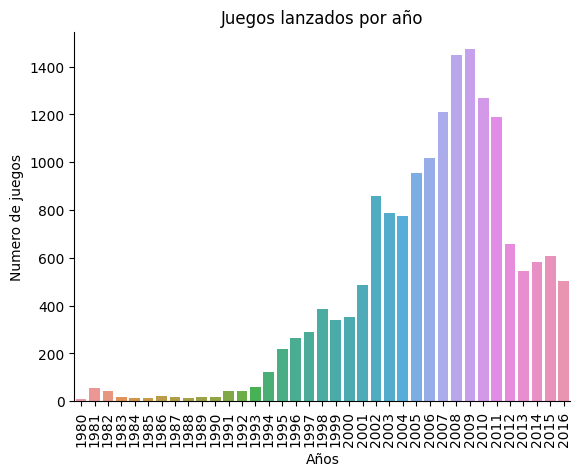

In [12]:
#Agrupar los datos por año y contar los juegos que se lanzaron ese año

games_per_year=df_game.groupby("year_of_release")["name"].size().reset_index()

#Graficar los resultados, como es comparativa, podemos usar la grafica de barras.

sns.barplot(x="year_of_release",y="name",data=games_per_year)
plt.xticks(rotation=90)
plt.title("Juegos lanzados por año")
plt.xlabel("Años")
plt.ylabel("Numero de juegos")

#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


plt.show()

Lo que vemos en la grafica es que la mayoria tuvo un crecimiento exponencial desde el año 2000, llegando a su auge en el año 2008 y 2009. por lo que ahora pasaremos a analizar las ventas por plataforma. Esto para ver como es su distribución.

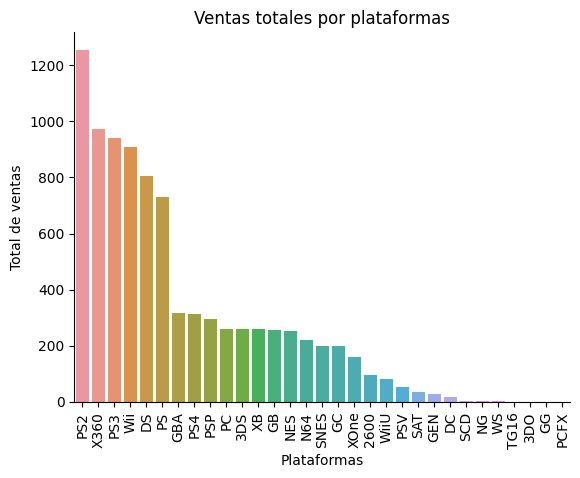

In [13]:
#Agrupamos los valores de plataformas por ventas totales

sales_for_platform=df_game.groupby("platform")["venta_total"].sum().reset_index().sort_values(by="venta_total",ascending=False)

sns.barplot(x="platform",y="venta_total",data=sales_for_platform)
plt.xticks(rotation=90)
plt.title("Ventas totales por plataformas")
plt.xlabel("Plataformas")
plt.ylabel("Total de ventas")

#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()

Estos datos si que son muy impresionantes. Lo que vemos es que solo 6 plataformas tienen casi el 90% de ventas. Primero vamos a ver cual es el tiempo de vida de las plataformas. Esto lo lograremos agrupando datos de acuerdo a la plataforma y los años, para saber sus ventas totales.

Ahí veremos en que fechas son cuando empezaron las ventas y cuando dejo de haber ventas.
Una vez tenemos eso, vamos a obtener una media de cuanto tardan las plataformas en dejar de tener ventas.

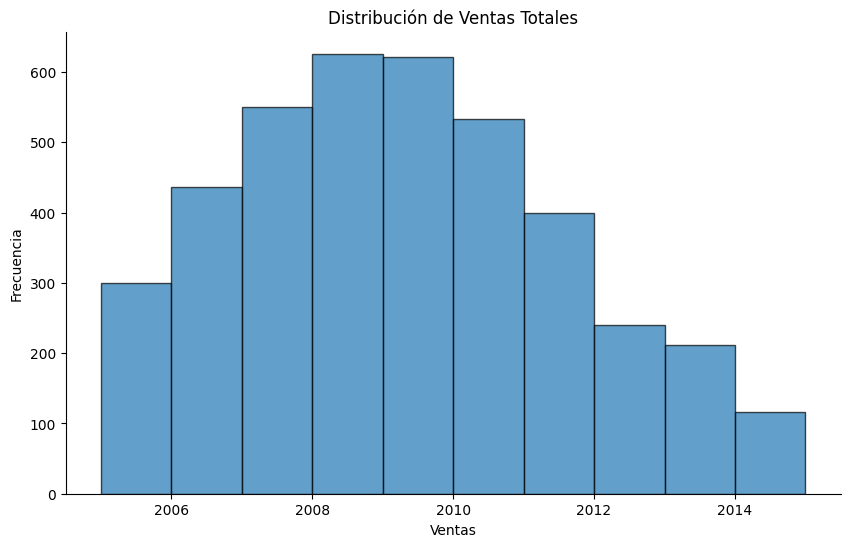

In [14]:
#Primero obtenemos las primeras 3 plataformas con mayores ventas

data_group=df_game.groupby("platform")["venta_total"].sum().nlargest(5).index

#Ahora filtramos nuestro dataframe para que nos salgan solo las plataformas con mayores ventas

filter_data = df_game[df_game["platform"].isin(data_group)]
ventas_por_año=filter_data.groupby("year_of_release")["venta_total"].sum().reset_index()


#Graficas un histograma para ver la distribución de ventas por año

plt.figure(figsize=(10,6))
plt.hist(ventas_por_año['year_of_release'],
         bins=range(2005,2016),
         weights=ventas_por_año['venta_total'],
         edgecolor='black',
         alpha=0.7)

plt.title('Distribución de Ventas Totales')
plt.xlabel('Ventas')
plt.ylabel('Frecuencia')

#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


plt.show()

Muchas gracias! Ya hice la correción y pongo las ventas a partir del 2006 al 2016. Si bien, son más años, en 5 no se podía ver bien la tendencia, de aquí se llega a ver la tendencia de las ventas.

En este histograma podemos ver que tiene una tendencia hacia le derecha y que no tiene una distribución normal. 

Lo que veo es que las ventas de estas plataformas salieron desde el año 2000 y fue que incremetaron mucho su venta durante 8 a 9 años.

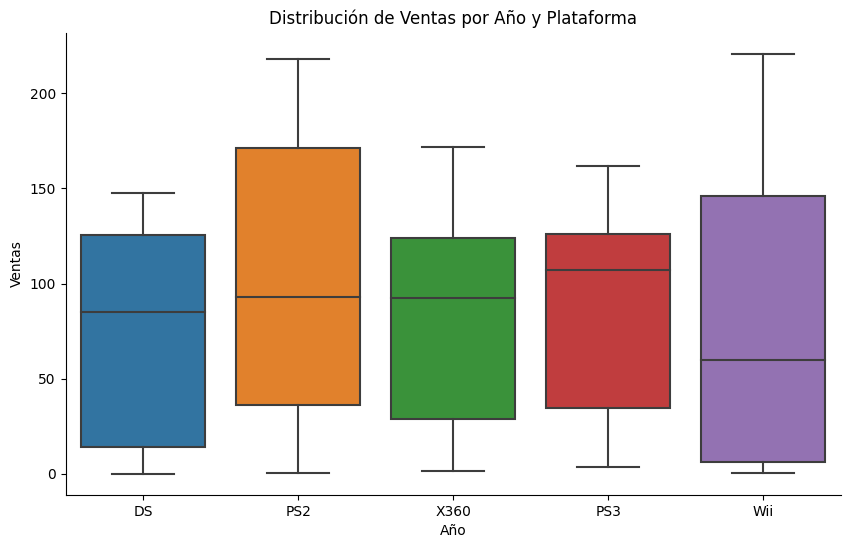

In [15]:
#Ahora vamos a graficar diagramas de cajas para todas las ventas por año de las plataformas con mayores ventas

plt.figure(figsize=(10,6))

platforms_years=filter_data.groupby(["year_of_release","platform"])["venta_total"].sum().reset_index()


sns.boxplot(x="platform",y="venta_total",data=platforms_years)

plt.title('Distribución de Ventas por Año y Plataforma')
plt.xlabel('Año')
plt.ylabel('Ventas')

#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


plt.show()


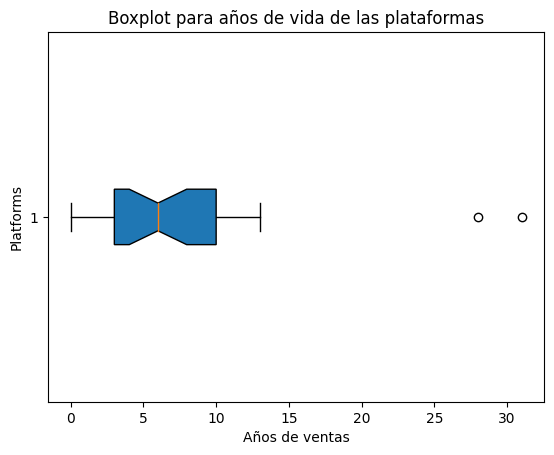

In [16]:
#Vamos a ver la diferencia de años de las plataformas de cuando salen y cuando sus ventas son nulas

sale_for_platform=df_game.groupby(["platform","year_of_release"])["venta_total"].sum().reset_index()
dif_year_min=sale_for_platform.groupby("platform")["year_of_release"].min()
dif_year_max=sale_for_platform.groupby("platform")["year_of_release"].max()

#Obtenemos las diferencias restando el año maximo y el año minimo (o año en que se lanzaron)

dif_year=dif_year_max - dif_year_min


# Graficamos un diagrama de caja para ver el intervalo

plt.boxplot(dif_year,patch_artist=True,notch=True,vert=0)
plt.xlabel("Años de ventas")
plt.ylabel("Platforms")
plt.title("Boxplot para años de vida de las plataformas")

plt.show()

Lo que vamos a observar es que tenemos un intervalo de entre 4 y 10 años. Teniendo una media de 6 años.

Entonces podemos decir que la mayoría de las plataformas tienen una duración de 6 años y que después de eso, las ventas o son muy bajas o son 0.

Vamos a ver el comportamiento de las plataformas con mayores ventas.

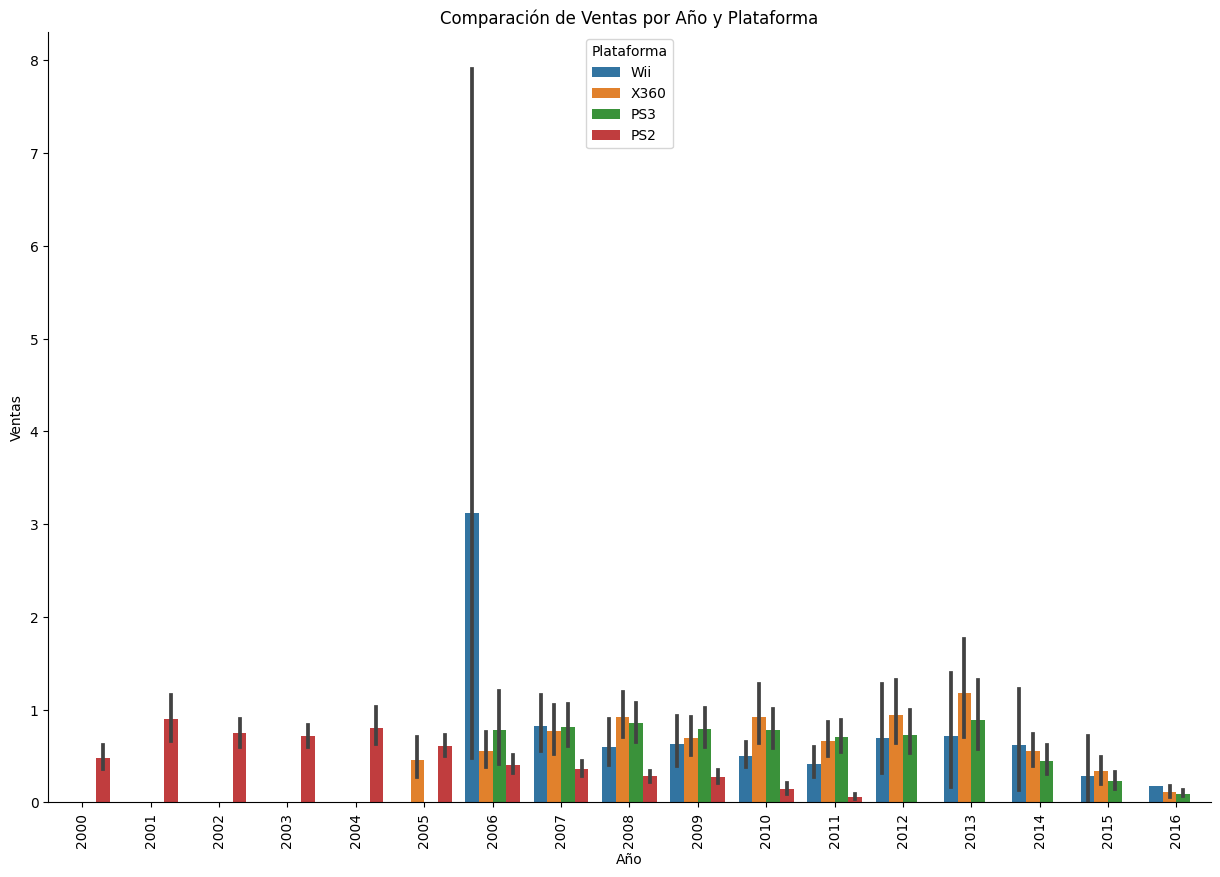

In [17]:
#Vamos a graficar pero ahora con una grafica de barras, las 4 plataformas con mayores ventas.

top_platforms=sales_for_platform.nlargest(4,columns="venta_total")["platform"].tolist()


#Filtramos los datos para que solo salgan las plataformas con mayores ventas

df_top=df_game[df_game["platform"].isin(top_platforms)]


#Graficamos los datos

plt.figure(figsize=(15, 10))
sns.barplot(x='year_of_release', y='venta_total', hue='platform', data=df_top)

plt.xticks(rotation=90)
plt.title('Comparación de Ventas por Año y Plataforma')
plt.xlabel('Año')
plt.ylabel('Ventas')
plt.legend(title='Plataforma')

#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


plt.show()

Con este grafico nos demuestra que para la consola del PS2 sus ventas empezaron en el 2000 y por lo que se aprecia terminaron en el 2011. Lo cual podemos decir fue un exito y entra en el rango del "boxplot" anterior.

Ahora vamos a seleccionar los datos que sean relevantes para lo que buscamos que es una predicción para el 2017. 

Para eso nos ayudaremos con el boxplot, y viendolo vamos a traer solo datos que sean de 6 años anteriores, por lo que estaremos contemplando ventas desde 2010 al 2016.


Vamos a automatizar un poco el analisis para cuando se desee hacer una predicción para otros años. 

Por lo que haremos una función que nos devuelva los 7 años posteriores del año de predicción que queramos hacer.

## Prediccion años

In [18]:
def year_pred(year_data):
    """Esta función nos ayudará a extraer los años posteriores para una predicción para el año 2017"""
    year_dates=[]
    for year in  range(year_data-6,year_data):
        year_dates.append(year)
    return year_dates

year_dates=year_pred(2017)
print(year_dates)
        


[2011, 2012, 2013, 2014, 2015, 2016]



Ya que tenemos los años necesarios, vamos a filtrar los datos solo para esos años.

In [19]:
#Filtramos los datos que necesitamos nada más.

data_pred=df_game[df_game["year_of_release"].isin(year_dates)].reset_index()

print(data_pred)


      index                            name platform  year_of_release  \
0        16              Grand Theft Auto V      PS3             2013   
1        23              Grand Theft Auto V     X360             2013   
2        29  Call of Duty: Modern Warfare 3     X360             2011   
3        31       Call of Duty: Black Ops 3      PS4             2015   
4        33             Pokemon X/Pokemon Y      3DS             2013   
...     ...                             ...      ...              ...   
4080  16703                Strawberry Nauts      PSV             2016   
4081  16707                Aiyoku no Eustia      PSV             2014   
4082  16710   Samurai Warriors: Sanada Maru      PS3             2016   
4083  16712         Haitaka no Psychedelica      PSV             2016   
4084  16714             Winning Post 8 2016      PSV             2016   

             genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
0           Action      7.02      9.09      

Bien! ya que tenemos los datos relevantes. Ahora vamos a trabajar con ellos.

Lo primero vamos a ver el comportamiento de las plataformas.

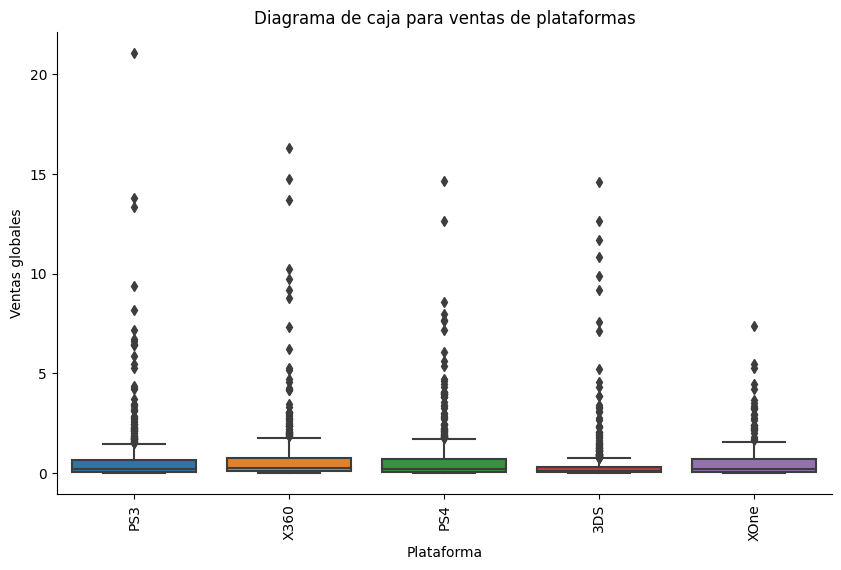

In [20]:
#Graficamos los datos con un diagrama de caja para ver sus ventas.

data_graficas=data_pred.groupby("platform")["venta_total"].sum().nlargest(5).index
data_filtrada=data_pred[data_pred["platform"].isin(data_graficas)]
data_group=data_filtrada.groupby(["platform","name"])["venta_total"].sum().reset_index()
    
plt.figure(figsize=(10, 6))
sns.boxplot(x="platform",y="venta_total",data=data_filtrada)
plt.xticks(rotation=90)
plt.title("Diagrama de caja para ventas de plataformas")
plt.xlabel("Plataforma")
plt.ylabel("Ventas globales")   

#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

    
plt.show()

Lo que vemos con ayuda del diagrama de cajas es que para las plataformas más populares no hay gran variación en sus ventas promedio, sus diagramas de cajas son muy parecidos. Lo que podemos decir es que hay muchos valores atipicos. Ya que suelen tener ventas muy grandes y esto pasa con todas las plataformas. 

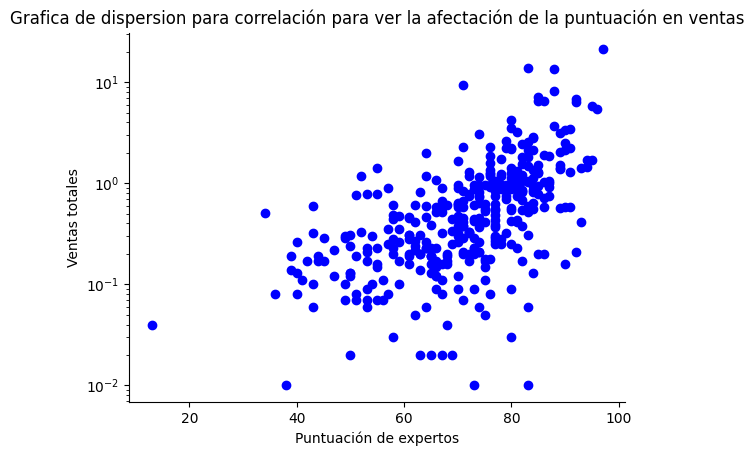

In [21]:
#Con una grafica de dispersión nos apoyamos para ver como se comportan la calificación de los criticos con las ventas

data_ps3=data_pred[data_pred["platform"]=="PS3"]

plt.scatter(data_ps3["critic_score"],data_ps3["venta_total"],c="blue")

plt.xlabel("Puntuación de expertos")
plt.ylabel("Ventas totales")
plt.title("Grafica de dispersion para correlación para ver la afectación de la puntuación en ventas")
plt.yscale("log")

#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

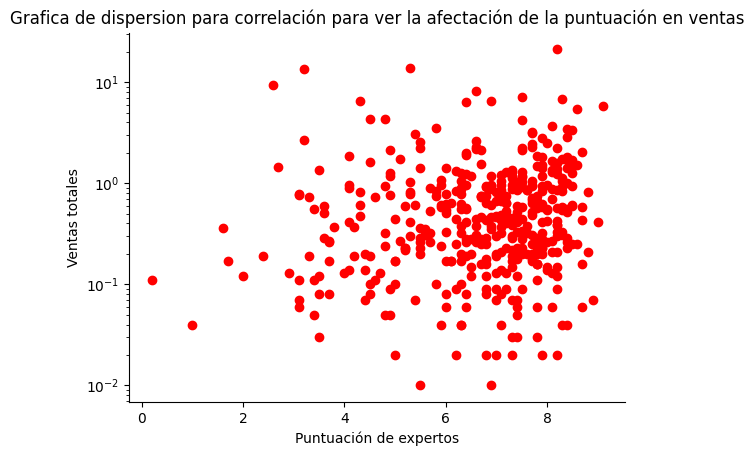

In [22]:
#Con la ayuda de una grafica de dispersion vemos el comportamiento de la calificación de los usuarios con las ventas.

plt.scatter(data_ps3["user_score"],data_ps3["venta_total"],c="red")
plt.xlabel("Puntuación de expertos")
plt.ylabel("Ventas totales")
plt.title("Grafica de dispersion para correlación para ver la afectación de la puntuación en ventas")
plt.yscale("log")


#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

In [23]:
data_ps3.corr()

,index,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,venta_total
index,1.000000,0.279713,-0.500914,-0.431579,-0.336129,-0.442639,-0.560983,-0.159295,-0.490849
year_of_release,0.279713,1.000000,-0.146131,-0.092903,-0.054396,-0.099111,-0.036589,-0.218231,-0.119324
na_sales,-0.500914,-0.146131,1.000000,0.837450,0.331698,0.875462,0.399059,0.007687,0.937823
eu_sales,-0.431579,-0.092903,0.837450,1.000000,0.352007,0.979266,0.339643,-0.016982,0.968841
jp_sales,-0.336129,-0.054396,0.331698,0.352007,1.000000,0.357108,0.201107,0.171351,0.434152
other_sales,-0.442639,-0.099111,0.875462,0.979266,0.357108,1.000000,0.350354,0.011940,0.977982
critic_score,-0.560983,-0.036589,0.399059,0.339643,0.201107,0.350354,1.000000,0.559140,0.379837
user_score,-0.159295,-0.218231,0.007687,-0.016982,0.171351,0.011940,0.559140,1.000000,0.011883
venta_total,-0.490849,-0.119324,0.937823,0.968841,0.434152,0.977982,0.379837,0.011883,1.000000


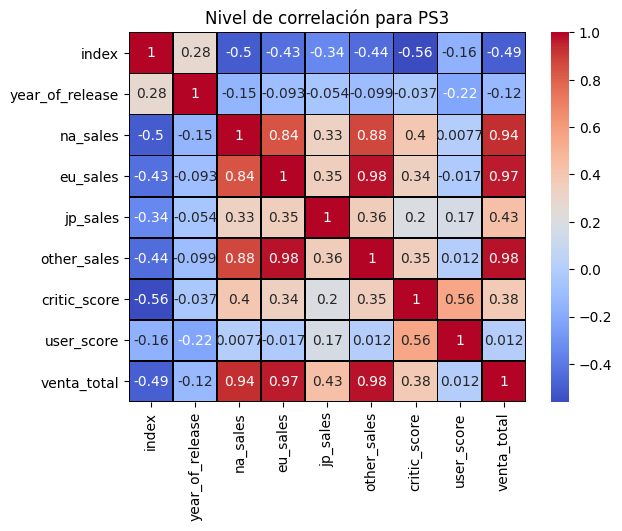

In [24]:
# Graficamos las correlaciones para la plataforma "PS3" y vemos cuales se relacionan con las ventas.
sns.heatmap(data_ps3.corr(),annot=True,
           cmap="coolwarm",
           cbar=True,
           linewidths=0.5,
           linecolor="black")

plt.title("Nivel de correlación para PS3")

plt.show()

Al revisar todas las posibles correlaciones, podemos observar que tiene mucho más valor la critica de los expertos que la de los usuarios.
Sin embargo obteniendo el coeficiente de correlación, vemos que es apenas un .38, lo cual no indica una correlación muy fuerte, pero si podemos decir que mientras más alta sea la puntuación de los expertos, afectará al incremento de las ventas.

Donde podemos ver una correlación fuerte es en las ventas "NA", lo cual indica que la mayor parte de ventas se da en "norte America", y si tienen un exito ahí, también lo tendran en las demas partes del mundo.

## Mejores plataformas y juegos

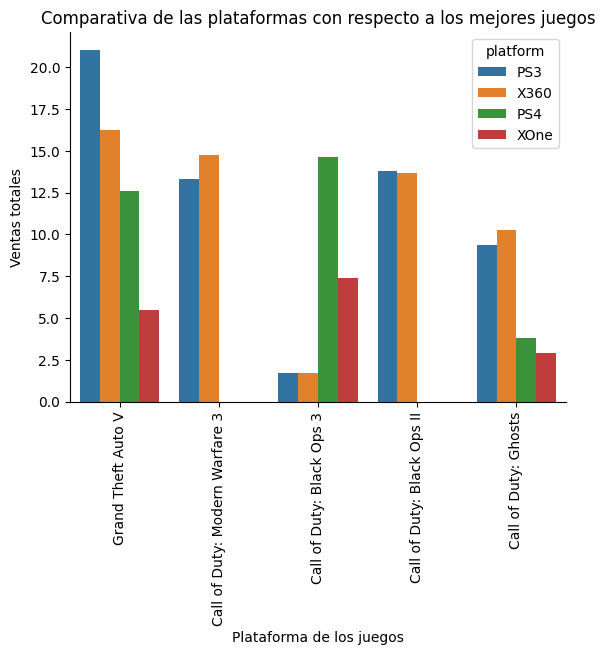

In [25]:
#Graficaremos cuales son los mejores juegos que han tenido mayor venta.

games_platform=data_pred.groupby("name",)["venta_total"].sum().nlargest(5).index


# Filtramos los datos para que nos de las mejores plataformas y los mejores juegos

data_games=data_pred[(data_pred["platform"].isin(data_graficas))&(data_pred["name"].isin(games_platform))]

#Graficamos los resultados

sns.barplot(x="name",y="venta_total",hue="platform",data=data_games)

plt.xticks(rotation=90)
plt.xlabel("Plataforma de los juegos")
plt.ylabel("Ventas totales")
plt.title("Comparativa de las plataformas con respecto a los mejores juegos")

#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

En este caso filtramos los datos para los juegos más vendidos y para las plataformas con mayores ventas. lo interesante es que vemos que los mayores juegos se vendieron en 2 principales plataformas, como es "PS3 y X360", la cual vimos antes que eran las plataformas con mayores ventas.
Lo raro aquí es que una de las principales plataformas también era Wii, sin embargo, tiene ventas muy bajas o nulas. lo cual puede indicar que para la Wii. 

podemos pensar que es por la interfaz de cada plataforma, ya que los juegos son de acción y requieren un control diferente al que tiene el Wii, por eso podemos ver que la mayoría de ventas están en las plataformas de PS3 y XOne

Ahora vamos a analizar por generos. veamos que podemos descubrir de ellos.

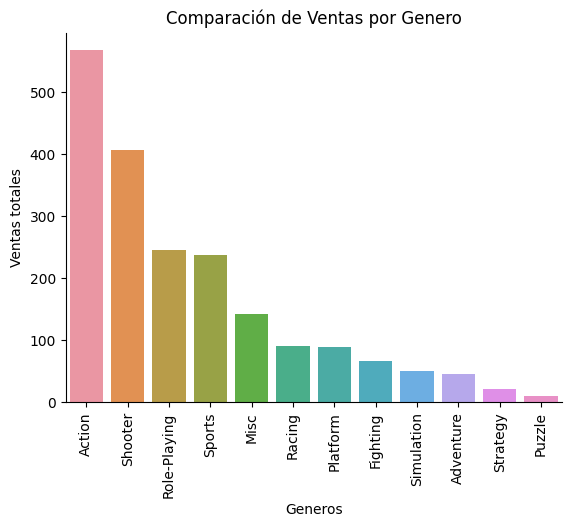

In [26]:
#Ahora vamos a graficar los generos para ver cuales fueron los más vendidos
data_genre=data_pred.groupby("genre")["venta_total"].sum().reset_index().sort_values(by="venta_total",ascending=False)

sns.barplot(x="genre",y="venta_total",data=data_genre)
plt.title("Comparación de Ventas por Genero")
plt.xlabel("Generos")
plt.ylabel("Ventas totales")
plt.xticks(rotation=90)


#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

Bueno, lo que podemos ver es que si podemos generalizar diciendo que:

Los juegos de action venden casi el doble que los juegos de deportes y casi 1.5 más que los juegos de disparos.
Podemos decir que las personas prefieren los juegos de acción y de disparos.

Ya sea porque muchos se pueden conectar en linea, jugar con diferentes amigos u otras razones. Pero si saldrá un juego nuevo y es de acción. es muy probable que se venda en un principio.

Y para los juegos con muy poca ventas creo que el mercado es más reducido, ya que no a todos les gustan ese tipo de videjuegos, sería interesante ver las edades de las personas que juegan cada genero, eso nos podría decir aun más a que personas van dirigidos cada uno de ellos.

# Perfiles por region

Bien, ya hicimos un analisis de ventas globales y el exito en todo el mundo. Pero, ahora vayamos un poco más especifico y vamos a analizar las ventas por regiones para ver cuál es la región que más vende y la que menos vende.

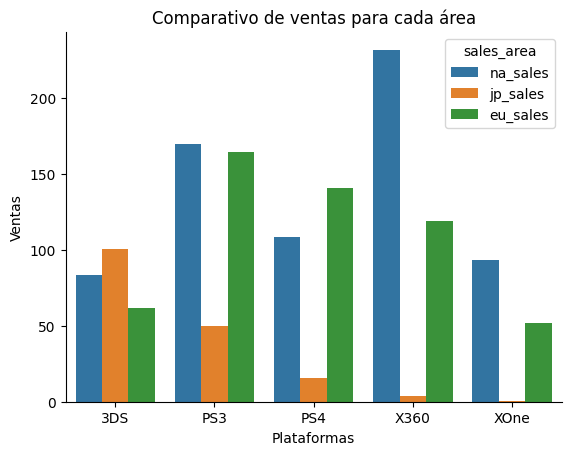

In [27]:
#Vamos a descubrir las regiones que venden más.
#En este caso vamos a agrupar por plataforma y sumaremos las ventas de cada region

top_platform=data_pred[data_pred["platform"].isin(data_graficas)]
data_region=top_platform.groupby("platform")["na_sales","jp_sales","eu_sales"].sum().reset_index()


#Luego convertiremos esos datos agrupados en una tabla, con la que podemos graficas las tres y tener una comparativa en el mismo grafico 

region_table= pd.melt(data_region,id_vars="platform",value_vars=["na_sales","jp_sales","eu_sales"],var_name="sales_area",value_name="sales")


#Graficamos los resultados

sns.barplot(x="platform",y="sales",hue="sales_area",data=region_table)

plt.title("Comparativo de ventas para cada área")
plt.xlabel("Plataformas")
plt.ylabel("Ventas")

#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()


Lo que vemos en este comparativo de ventas es impresionante, vemos que en la mayoria de las consolas las mayores ventas fueron en "na" y en el caso de X360 la diferencia se nota muchisimo, en segundo lugar vemos que es "EU" y por ultimo será la región de "JP".

Las ventas pueden ser también por el nivel de población. En este caso tomo datos de la

<h6> población del año 2014 para las 3 regiones las cuales son: </h6>

<h6> Población NA: 450 Millones </h6>
<h6> Población EU: 318 Millones </h6>
<h6> Población JP: 127 Millones </h6>

Si vemos estos números podemos pensar el porque NA tiene las mayores ventas, y es porque en NA hay más población, por lo que hay mucho más mercado que en la región de JP con solo 127 Millones, siendo menos de la mitad de la población de NA.

Ahora vamos a ver las ventas de los 5 generos principales

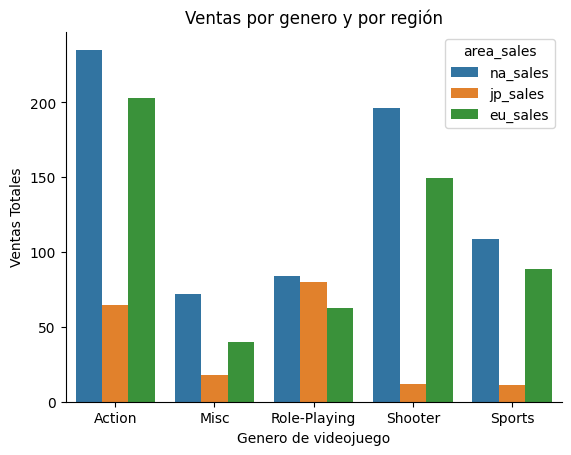

In [28]:
#Hacemos lo mismo, encontraremos los generos más vendidos

top_genre=data_pred.groupby("genre")["venta_total"].sum().nlargest(5).index
#filtramos los datos para que solo tengamos los mejores generos

data_region_genre=data_pred[data_pred["genre"].isin(top_genre)]

#Agrupamos por genero y sumamos la ventas de cada región

genre_per_region=data_region_genre.groupby("genre")["na_sales","jp_sales","eu_sales"].sum().reset_index()

#Convertimos el agrupamiento en un tabla para graficarlos

genre_per_region_table=pd.melt(genre_per_region,id_vars="genre",value_vars=["na_sales","jp_sales","eu_sales"],var_name="area_sales",value_name="sales")

#Graficamos los resultados

sns.barplot(x="genre",y="sales",hue="area_sales",data=genre_per_region_table)
plt.title("Ventas por genero y por región")
plt.xlabel("Genero de videojuego")
plt.ylabel("Ventas Totales")


#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

Vemos un poco parecido el tema. Las ventas que son mayores son por parte de NA en la mayoría de juegos.

Si bien, podemos destacar en algo, es que en las region de JP es la región en la que menos hay venta en los juegos más vendidos, en este caso acción y Shooter. en shooter apenas podemos ver que hay ventas. 

Sin embargo, les gusta más el role-playing. Entonces si quisieramos sacar un nuevo juego, podemos predecir donde puede tener mayor exito. En este caso los juegos de acción y shooter serán un exito en las regiones de NA y EU. Pero en JP no tendrá las ventas esperadas.

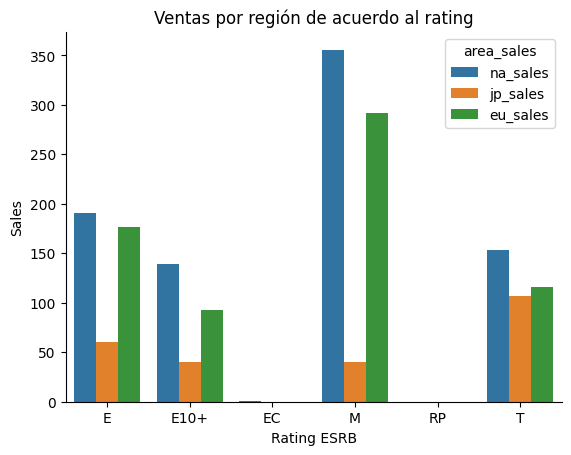

In [29]:
#Aquí agrupamos por rating (ESRB) y sumamos las ventas de las regiones

sales_rating=data_pred.groupby("rating")["na_sales","jp_sales","eu_sales"].sum().reset_index()

#Convertimos en tabla el agrupamiento
sales_rating_table=pd.melt(sales_rating,id_vars="rating",value_vars=["na_sales","jp_sales","eu_sales"],var_name="area_sales",value_name="sales_rating")

#Graficamos los resultados

sns.barplot(x="rating",y="sales_rating",hue="area_sales",data=sales_rating_table)
plt.title("Ventas por región de acuerdo al rating")
plt.xlabel("Rating ESRB")
plt.ylabel("Sales")

#Quitar las lineas derecha y de arriba para mejor visualización
ax=plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


plt.show()

Aquí dejo la clasificación de las que tenemos: 

###### E = Para todos, es apto para cualquier persona
###### E+10 = Para cualquier persona que sea mayor de 10 años
###### EC = Dice que es para niños de 3 años en adelante
###### M = Es para personas mayores de 17 años
###### RP = esto significa que no tiene un rating
###### T = Es para personas mayores de 13 años.

<p> Teniendo la clasificación en cuenta, podemos decir que los videojuegos que más se venden son la clasificación "M" que son los mayores a 17 años. Y donde tienen un mayor impacto es en NA. 
En la región de JP no se venden mucho esos juegos, esto puede ser por la cultura o la restricción de los padres. 

Lo que tenemos muy impresionante es sobre los RP y EC. Esto puede ser que las calificaciones si afecten directamente las ventas. Esto lo vemos porque al no tener un rating no hay ventas significativas o bien, son nulas las ventas. 
Y por el otro lado vemos que los juegos que son para menores de 3 años, las ventas son igualmente nulas o bien son muy bajas.

Esto es porque vemos a pocos niños que tengan una consola, o que estén jugando mayormente en una consola, en la epoca del 2000 al 2015 todavía los niños salian a jugar un poco más. Sin embargo, sería interesante ver como ha crecido el mundo de los videojuegos despues del 2020 </p>

# Prueba de Hipotesis

Ahora que tenemos más datos. Vamos a definir y probar algunas hipotesis con los datos que tenemos.

En este caso nuestra hipotesis sera: Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

Vamos a definir nuestra hipotesis nula y la hipotesis alternativa, esto quedara de la siguiente forma:

Hipotesis nula (H0) = Las calificaciones promedio de los usuarios para XOne y PC son iguales
Hipotesis Alternativa (H1) = Las calificaciones promedio de los usuarios para Xone y PC no son iguales

vamos a elegir un nivel de confianza del 95%, por lo cual tendremos un alfa = 0.05

La prueba que realizaremos será un t studen de de media de poblaciones iguales, y estableceremos una equal_var=False.


utilizamos esta prueba, porque no son datos relacionados, y estamos haciendo la comparación de datos no relacionados. Por eso, esta es la prueba que realizamos.

In [30]:
data_not_na= data_pred[~data_pred["user_score"].isna()]


user_score_xone=data_not_na[data_not_na["platform"]=="XOne"]["user_score"]
user_score_pc=data_not_na[data_not_na["platform"]=="PC"]["user_score"]

alpha=0.05

results= st.ttest_ind(user_score_xone,user_score_pc,equal_var=False)

if results.pvalue<alpha:
    print("Se Rechaza la hipotesis nula, ya que no hay pruebas estadisticas suficiente para decir que las medias son iguales")
else:
    print("No podemos rechazar la hipotesus nula, estadisticamente hablando no hay pruebas suficientes para decir que son iguales")

print(results.pvalue)


No podemos rechazar la hipotesus nula, estadisticamente hablando no hay pruebas suficientes para decir que son iguales
0.6837991405221536


Después de realizar la prueba correspondiente, podemos decir que "no se rechaza la hipotesis nula"

Esto no quiere decir que las medias son iguales, pero, estadisticamente hablando no hay datos que nos digan que son iguales.

Vamos a pasar a la siguiente prueba de hipotesis la cual sera: 

Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

Si bien, vamos a establecer nuestras hipotesis. las cuales quedarán de la siguiente forma: 

Hipotesis nula (H0) = La media de los usuarios para los generos de acción y deportes son diferentes

Hipotesis alternativa (H1) = La media de los usuarios para los generos de acción y deportes no son diferentes.

El nivel de confianza en este caso será igual del 95%, lo cual tenemos un valor alpha= 0.05

utilizamos esta prueba, porque no son datos relacionados, y estamos haciendo la comparación de datos no relacionados. Por eso, esta es la prueba que realizamos.

In [31]:


user_score_action=data_not_na[data_not_na["genre"]=="Action"]["user_score"]
user_score_sports=data_not_na[data_not_na["genre"]=="Sports"]["user_score"]

alpha=0.05

results_genre=st.ttest_ind(user_score_action,user_score_sports,equal_var=False)

if results.pvalue<alpha:
    print("Se rechaza la hipotesis nula, ya que estadisticamente hablando, las medias si podrían ser iguales")
else:
    print("No se puede rechazar la hipotesis nula, ya que estadisticamente hablando, las medias si podrían ser diferentes")


print(results.pvalue)

No se puede rechazar la hipotesis nula, ya que estadisticamente hablando, las medias si podrían ser diferentes
0.6837991405221536


Al probar las hipotesis, podemos decir que las medias son diferentes, esto puede deberse a que son dos tipos de personas diferentes las que juegan juegos de acción y otro tipo de personas juegan los tipos de deportes.

también podemos pensar en esto porque hay más usuarios de acción que de deportes, esto también puede ser un factor de que la media para los de acción es más precisa que la de deportes.

# Conclusiones

A través de este proyecto completo, me di cuenta de muchas cosas, así como mis áreas de oportunidad para saber donde tengo que enfocarme y trabajar en esas partes. 

en la primera parte de importación de los datos: Me sentí muy comodo y fácil de usar, no tuve ningún problema para la importación y para leer la información general de los datos.

En la segunda parte que trata de la limpieza: aquí es donde encontré algunas áreas de oportunidad, me pareció que trabajar los datos en blanco no supe manejar muy bien al principio, ya que no tenía la noción o no sabía si tenia que eliminarlos, rellenarlos o que podía hacer. Al final después de preguntar me di cuenta que si era mejor no rellenar alguno de los datos, porque estaría sesgando los datos. En este caso también para rellenar y definir las funciones tuve que investigar e indagando información porque no comprendía muy bien el como hacerlas.

en la tercera parte de las graficas: No me sentí tan perdido, sin embargo, me sentí mucho más comodo con la librería de "seaborn" que con "pyplot" para graficar. Creo que me gusto más y veo que tienen más diseños, al momento de agrupar no estuvo mal y creo que lo que hice con los graficos estuvo bien. Obvio sé que si la limpieza de datos no está bien en un principio, las graficas no demostrarán la información correcta.

En la cuarta parte para los perfiles: Creo que lo hice de otra manera, porque me parecía más trabajo hacer un dataframe para cada región, creo que las graficas que se hicieron de eso fueron acertadas y se ve la diferencia de las regiones.

En la quinta sección de las hipotesis: Fue un poco sencillo, pero también tuve problemas porque en un principio no me salía bien el resultado, después de investigar vi que si había valores ausentes, resultará 0 la probabilidad, por lo que, tuve que filtar los datos que no fueran ausentes y ahora si me salio un valor. (aun tengo dudas si se manejaron bien las hipotesis y la prueba que se hizo)

Como conclusión general:
Me gusto mucho el proyecto, de verdad parecio un problema de la vida real y tratar de manejarlo sin ayuda fue una parte dificil pero muy interesante, ya que de esta forma aprendemos mas. Tratar con los datos, graficar, limpieza de datos y todo sin ninguna instrucción, me parecio un reto muy divertido y de mucho aprendizaje.
Después de leer los datos y graficarlos te impresionas lo que se puede hacer, como ver que región es la que más vende, los generos que son más populares, encontrar la tendencia de las consolas de cuando aparecen y cuando desaparecen. 
Si bien, aun me falta aprender mucho y poder trabajar los datos de una manera más eficiente, seguire investigando y probando mis habilidades para ir mejorando cada vez más en el analisis de datos y en la visualización de ellos. 

Ahora sabemos que podemos lanzar más juegos de acción en la región de "NA" porque sabemos que hay muchas personas que lo compran.



